# Exploration of Imbalanced Banking Dataset Using Machine Learning

### Tucker Laurence, Ryan Worley

This notebook is a comprehensive report detailing the approaches and results of our CS345 project.

The dataset explored in this project contains data from direct marketing campaigns by a Portuguese bank, conducted through phone calls. The purpose of the calls was to determine whether the client answered “yes” or “no” to a bank term deposit subscription. Often, multiple contacts with the same client were necessary.

The data includes features relating to client information, such as age, job, marital status, and additional details like the method of contact, timing of the last contact, call duration, and more. Our target feature for classification is “has the client subscribed to a term deposit?” (binary: "yes" or "no"). We will analyze how the other features relate to this target feature and aim to build and train a machine learning model to classify clients’ responses as “yes” or “no” based on their information in the remaining features.

The challenge of this dataset lies in the inherent complexity of human behavior as reflected in the data. Clients' responses may be influenced by numerous factors, including demographics, previous contacts, and socio-economic indicators. Additionally, the requirement for multiple contacts introduces a temporal dimension, making the dataset more intricate. The high-dimensional feature space, coupled with the need for effective classification, poses an exciting challenge for machine learning algorithms. Furthermore, the dataset is heavily imbalanced. WIth nearly 7 times the amount of "yes" values than "no" values in the target feature, we had to explore methods of handling imbalanced datasets such as these.

In [1]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, accuracy_score, classification_report, confusion_matrix, recall_score

from sklearn.model_selection import KFold
import itertools

from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
def fetch_data(url="https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional.csv"):
    response = requests.get(url)
    data = StringIO(response.text)
    df = pd.read_csv(data, sep=";")
    return df

def show_data_info():
    data = fetch_data()
    data.info()

show_data_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

## Exploring the dataset before preprocessing and feature engineering

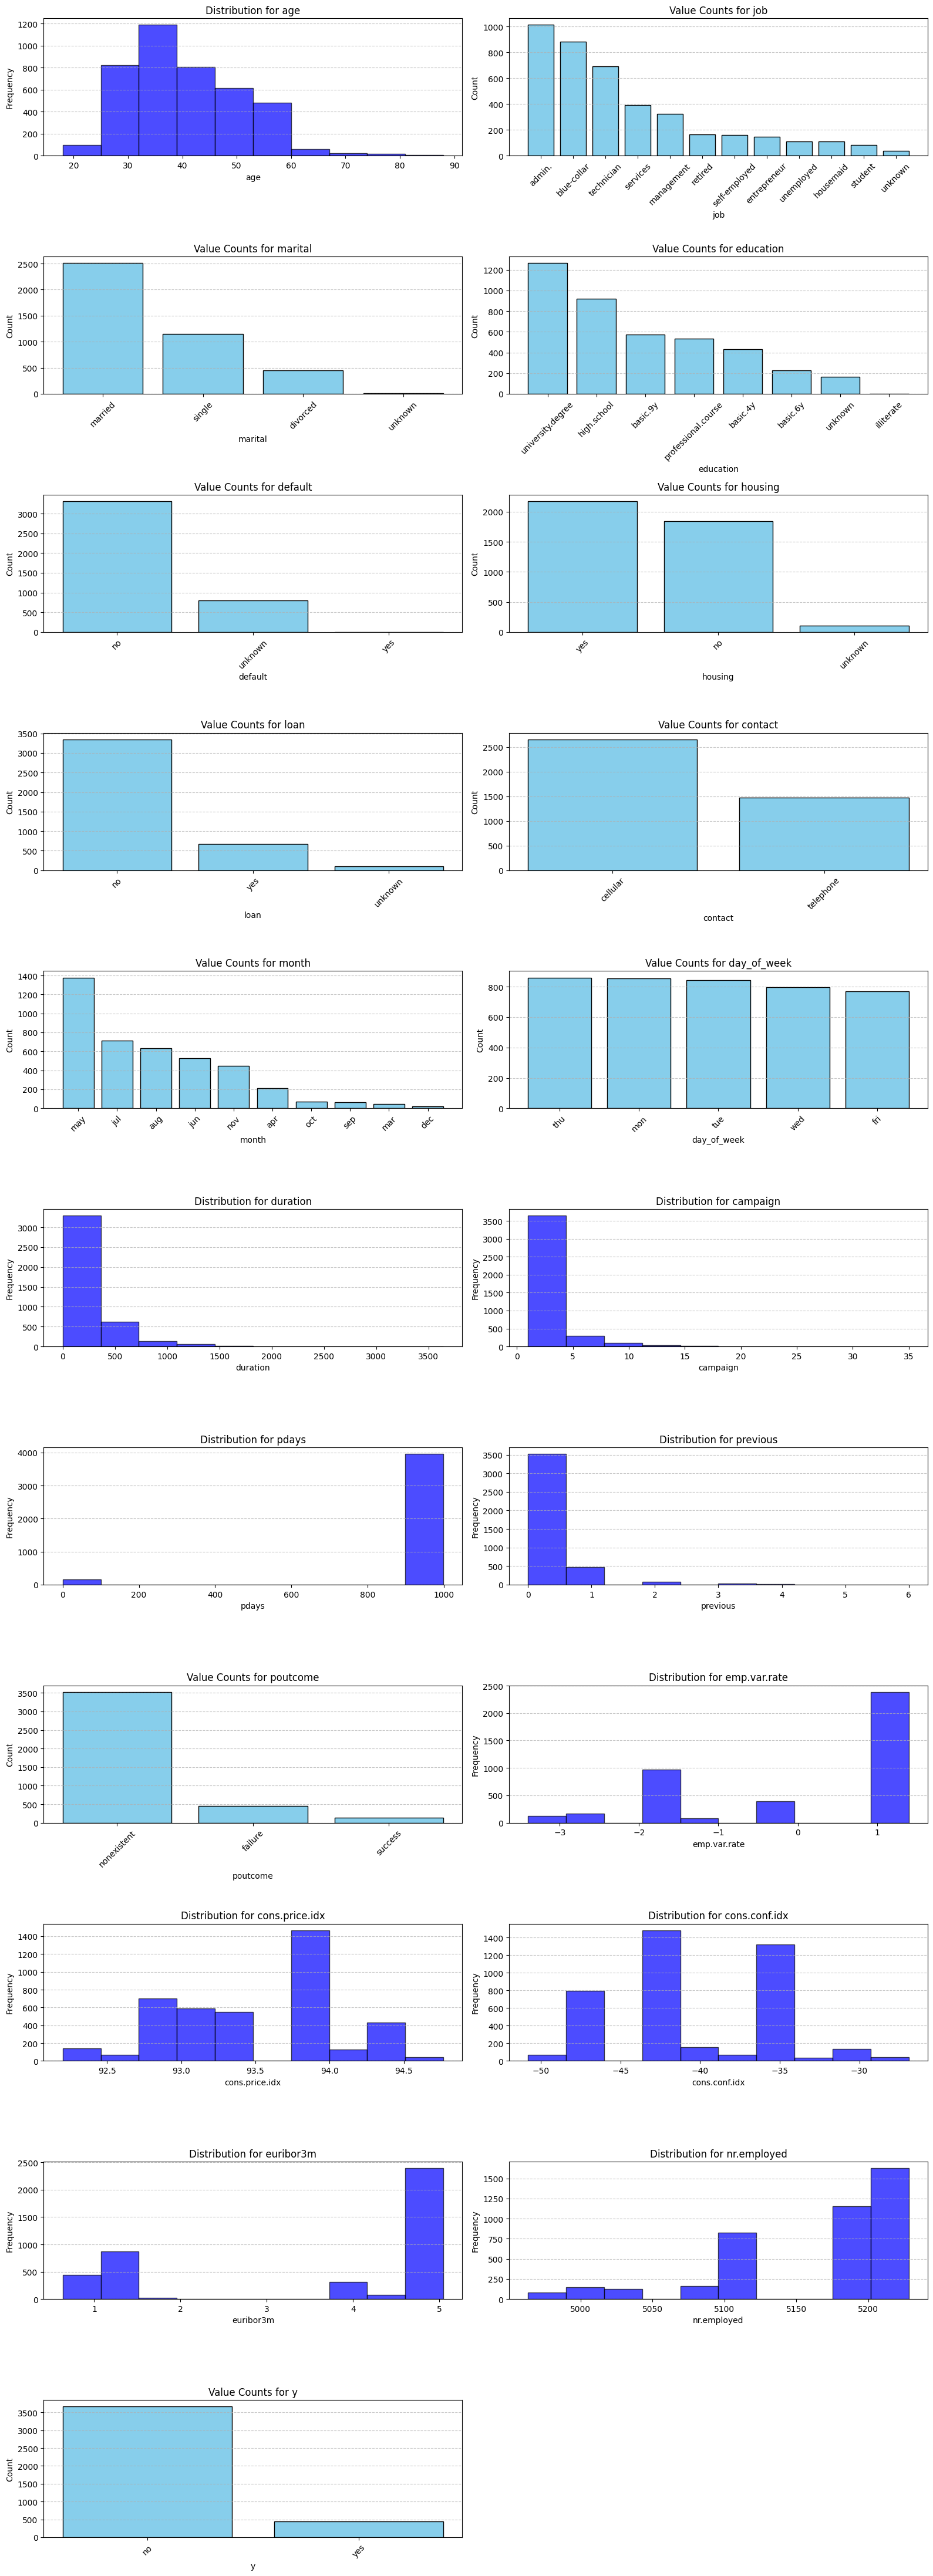

In [ ]:
def data_distribution_charts(data):
    num_columns = len(data.columns)
    rows = (num_columns + 1) // 2  # Calculate rows for a 2-column layout
    
    fig, axes = plt.subplots(rows, 2, figsize=(16, 4 * rows))  # Dynamic figure size
    axes = axes.flatten()  # Flatten the axes array to access them easily
    
    for i, column in enumerate(data.columns):
        ax = axes[i]  # Select the appropriate subplot
        
        if data[column].dtype == 'object':  # Categorical data
            value_counts = data[column].value_counts()
            ax.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
            ax.set_title(f"Value Counts for {column}")
            ax.set_xlabel(column)
            ax.set_ylabel("Count")
            ax.tick_params(axis='x', rotation=45)
        else:  # Numeric data
            ax.hist(data[column], bins=10, color='blue', edgecolor='black', alpha=0.7)
            ax.set_title(f"Distribution for {column}")
            ax.set_xlabel(column)
            ax.set_ylabel("Frequency")
        
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def show_data_distribution() :
    data = fetch_data()
    data_distribution_charts(data)

show_data_distribution()

In [4]:
def print_unique_values(data):
    for column in data.columns:
        unique_values = data[column].unique()
        print(f"Unique values in column '{column}': {unique_values}")

def show_unique_values():
    data = fetch_data()
    print_unique_values(data)

show_unique_values()

Unique values in column 'age': [30 39 25 38 47 32 41 31 35 36 29 27 44 46 45 50 55 40 28 34 33 51 48 20
 76 56 24 58 60 37 52 42 49 54 59 57 43 53 75 82 71 21 22 23 26 81 61 67
 73 18 64 74 77 86 85 63 88 78 72 68 80 66 19 62 65 69 70]
Unique values in column 'job': ['blue-collar' 'services' 'admin.' 'entrepreneur' 'self-employed'
 'technician' 'management' 'student' 'retired' 'housemaid' 'unemployed'
 'unknown']
Unique values in column 'marital': ['married' 'single' 'divorced' 'unknown']
Unique values in column 'education': ['basic.9y' 'high.school' 'university.degree' 'professional.course'
 'basic.6y' 'basic.4y' 'unknown' 'illiterate']
Unique values in column 'default': ['no' 'unknown' 'yes']
Unique values in column 'housing': ['yes' 'no' 'unknown']
Unique values in column 'loan': ['no' 'unknown' 'yes']
Unique values in column 'contact': ['cellular' 'telephone']
Unique values in column 'month': ['may' 'jun' 'nov' 'sep' 'jul' 'aug' 'mar' 'oct' 'apr' 'dec']
Unique values in column 'day

In [5]:
def check_column_type(data):
    for column in data.columns:
    # Check if the column is of integer type
        if pd.api.types.is_integer_dtype(data[column]):
            min_val = data[column].min()
            max_val = data[column].max()
            range_size = max_val - min_val + 1
            print(f"Column '{column}' is of integer type. Range size: {range_size}")
        
        elif pd.api.types.is_float_dtype(data[column]):
            min_val = data[column].min()
            max_val = data[column].max()
            range_size = max_val - min_val + 1
            print(f"Column '{column}' is of float type. Range size: {range_size}")
        
        # Check if the column is categorical
        elif data[column].dtype == 'object':
            num_categories = data[column].nunique()
            print(f"Column '{column}' is categorical. Number of categories: {num_categories}")
        
        else:
            print(f"Column '{column}' is neither integer nor categorical.")


def show_column_types():
    data = fetch_data()
    check_column_type(data)

show_column_types()


Column 'age' is of integer type. Range size: 71
Column 'job' is categorical. Number of categories: 12
Column 'marital' is categorical. Number of categories: 4
Column 'education' is categorical. Number of categories: 8
Column 'default' is categorical. Number of categories: 3
Column 'housing' is categorical. Number of categories: 3
Column 'loan' is categorical. Number of categories: 3
Column 'contact' is categorical. Number of categories: 2
Column 'month' is categorical. Number of categories: 10
Column 'day_of_week' is categorical. Number of categories: 5
Column 'duration' is of integer type. Range size: 3644
Column 'campaign' is of integer type. Range size: 35
Column 'pdays' is of integer type. Range size: 1000
Column 'previous' is of integer type. Range size: 7
Column 'poutcome' is categorical. Number of categories: 3
Column 'emp.var.rate' is of float type. Range size: 5.8
Column 'cons.price.idx' is of float type. Range size: 3.5660000000000025
Column 'cons.conf.idx' is of float type. 

In [6]:
def get_unknown_percentage(df, dataset_name="Data"):
    unknown_percentages = {}
    unknown_columns_count = 0

    # Loop over each column in the dataframe
    for column in df.columns:
        # Count the occurrences of 'unknown' in the column
        unknown_count = (df[column] == 'unknown').sum()

        if column == "pdays":
            unknown_count += (df[column] == 999).sum()

        unknown_count += (df[column].isna()).sum()

        # Calculate the percentage of 'unknown' values
        total_count = len(df[column])
        unknown_percentage = (unknown_count / total_count) * 100

        # Store the percentage in the dictionary
        unknown_percentages[column] = unknown_percentage
        if unknown_percentage > 0:
            unknown_columns_count += 1
            print(f"{dataset_name} - {column} unknowns: {unknown_percentage}%")

    if unknown_columns_count == 0:
        print(f"{dataset_name} - No unknowns in the data.")
    return unknown_percentages

def show_unknown_percentage():
    data = fetch_data()
    get_unknown_percentage(data)

show_unknown_percentage()

Data - job unknowns: 0.9468317552804079%
Data - marital unknowns: 0.2670551104637048%
Data - education unknowns: 4.054382131585337%
Data - default unknowns: 19.49502306385045%
Data - housing unknowns: 2.5491624180626364%
Data - loan unknowns: 2.5491624180626364%
Data - pdays unknowns: 96.11556202961884%


From this investigation of data we can make the following assumptions:

Numerical features that should be standardized:

    age, duration, campaign, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Categorical features that should be one-hot encoded:

    job, marital, education, contact, poutcome

Binary features that need to be be transformed:

    default, housing, loan, y

Features lacking enough information, and should likely be dropped:

    pdays

Cyclical features that could be cyclically or one-hot encoded:

    day_of_week, month
    



## Feature Engineering and Preprocessing Functions

In [7]:
def drop_data(data, columns):
    data = data.drop(columns=columns, axis=1)

    return data

def map_columns(df, columns, mapping):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].map(mapping)
    return df

def one_hot_encode_columns(df, columns):
    # Check if the specified columns exist in the dataframe
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not in the DataFrame: {', '.join(missing_cols)}")
    
    # Apply one-hot encoding to the specified columns
    df_encoded = pd.get_dummies(df, columns=columns, drop_first=False)

    df_encoded = df_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))
    
    return df_encoded

def encode_cyclic_information(df, column_name, mapping):
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Map the days to numbers
    df[column_name] = df[column_name].map(mapping)
    
    # Create sine and cosine features for cyclic encoding
    df[column_name + '_sin'] = np.sin(2 * np.pi * df[column_name] / 7)
    df[column_name + '_cos'] = np.cos(2 * np.pi * df[column_name] / 7)
    
    # Drop the original day column if you no longer need it
    df = df.drop(columns=[column_name])
    
    return df

def standardize_columns(data, columns):
    scaler = StandardScaler()
    for column in columns : 
        if column in data.columns:
            data[column] = scaler.fit_transform(data[[column]])
    return data

def create_nan_mask(data):
    for column in data.columns:
        if data[column].isna().any():  # Check if the column contains NaN values
            
            mask_column_name = f"{column}_unknown"
            
            data[mask_column_name] = data[column].apply(lambda x: 1 if pd.isna(x) else 0)
            
            column_mode = data[column].mode()
            if not column_mode.empty:
                mode_value = column_mode[0]
            else:
                mode_value = None 
            
            data[column] = data[column].fillna(mode_value)
    
    return data

In [8]:
def preprocessing(url="https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional.csv",mask_nans = True):
    binary_mapping = {
        'yes':1,
        'no':0,
        'unknown': None
        }

    days_mapping = {
            'sun': 0,
            'mon': 1,
            'tue': 2,
            'wed': 3,
            'thu': 4,
            'fri': 5,
            'sat': 6
        }

    months_mapping = {
            'jan': 0,
            'feb': 1,
            'mar': 2,
            'apr': 3,
            'may': 4,
            'jun': 5,
            'jul': 6,
            'aug': 7,
            'sep': 8,
            'oct': 9,
            'nov': 10,
            'dec': 11
        }

    binary_columns = ["default", "housing", "loan", "y"]
    categorical_columns = ["job", "marital", "education", "contact", "poutcome"]
    numerical_columns = ["age", "duration", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
    dropped_columns = ['pdays']

    data = fetch_data(url)
    
    #Remove Duplicate rows
    data = data[~data.duplicated()]

    #Drop necissary features
    data = drop_data(data, dropped_columns)

    #Map Binary values to 0,1,NaN
    data = map_columns(data, binary_columns, binary_mapping)

    #One hot encode categorical data
    data = one_hot_encode_columns(data, categorical_columns)

    # Perform Cyclical mapping for time data
    data = encode_cyclic_information(data, "day_of_week", days_mapping)
    data = encode_cyclic_information(data, "month", months_mapping)
    
    #Standardize Integer Columns
    data = standardize_columns(data, numerical_columns)
    
    if mask_nans :
        data = create_nan_mask(data)
        
    return data

In [9]:
def analyze_preprocessing():
    data = preprocessing()
    print("--------------")
    get_unknown_percentage(data)
    print("--------------")
    print_unique_values(data)
    print("--------------")
    check_column_type(data)

analyze_preprocessing()


--------------
Data - No unknowns in the data.
--------------
Unique values in column 'age': [-0.98075178 -0.10799146 -1.46561862 -0.20496483  0.66779548 -0.78680504
  0.08595527 -0.88377841 -0.49588494 -0.39891157 -1.07772515 -1.27167189
  0.37687538  0.57082212  0.47384875  0.95871559  1.44358243 -0.0110181
 -1.17469852 -0.59285831 -0.68983168  1.05568896  0.76476885 -1.95048547
  3.48002317  1.5405558  -1.56259199  1.73450254  1.92844928 -0.3019382
  1.15266233  0.18292864  0.86174222  1.34660906  1.83147591  1.63752917
  0.27990201  1.2496357   3.38304981  4.06186339  2.99515633 -1.8535121
 -1.75653873 -1.65956536 -1.36864526  3.96489002  2.02542264  2.60726286
  3.18910307 -2.1444322   2.31634275  3.28607644  3.57699654  4.44975686
  4.35278349  2.21936938  4.6437036   3.67396991  3.0921297   2.70423622
  3.86791665  2.51028949 -2.04745884  2.12239601  2.41331612  2.80120959
  2.89818296]
Unique values in column 'default': [0. 1.]
Unique values in column 'housing': [1. 0.]
Unique 

#### With our data properly preprocessed we will now attempt to solve the imbalanced data set issue through several methods

## Data Splitting and Sampling Methods

As discussed earlier in the notebook, this dataset is an example of imbalanced data. The target feature, “y” (binary “yes” or “no” feature describing whether or not the customer subscribed a term deposit) is heavily imbalanced. There are nearly seven times more yes answers than no's, which leads to interesting challenges when it comes to machine learning on the data.

First is the issue of actually training a model to effectively distinguish between the two classes. Training most models as you would on balanced data will not work, as machine learning models generally intend to minimize the error rate of classification. In the case of imbalanced data, there are so many more of one class than another that models tend to classify every sample into the majority class. A naive model using this approach will achieve a relatively high accuracy, but in reality is quite poor at being able to tell the two classes apart. In order to combat this, there are methods that can be utilized to train the models more effectively.

The two methods we have explored in this project are cost-sensitive learning and various sampling approaches.

The cost-sensitive methodology is to assign different weights to each class—i.e. assign a higher weight to the minority class. This leads to a greater punishment, or higher cost, for the incorrect classification of the minority class. The model then attempts to minimize the overall cost while training. Cost-sensitive learning helps the model decrease its tendency to over classify samples into the majority class.

Sampling may also be used to reduce the model’s bias towards one class. This is the approach of adjusting class distributions in the training data. You can either oversample the minority class or undersample the majority class.

Oversampling is performed by either duplicating existing samples from the minority class or generating new samples using the patterns found in existing ones. This increases the minority class size and exposes the model to more minority class data. Oversampling has the potential to lead to overfitting, as samples are duplicated/generated using known data, which can cause the model to learn specific patterns instead of generalized rules. However, it can be a quite effective technique to deal with imbalanced data.

In our project, we used both a custom oversampling function and the SMOTE class from the imbalanced-learn library to implement oversampling. The SMOTE technique increases minority class distribution by generating synthetic samples from existing ones. SMOTE is used to select a sample and another, neighboring sample from the minority class, then generate a new sample along the line between these two.

Undersampling, or down-sampling, reduces the size of the majority class by removing some values, also making class distribution more balanced. While this can potentially lead to the loss of valuable information, it is also an effective way to handle imbalanced data when utilized correctly.

Similarly to the oversampling function, we used the resample class from the imbalanced-learn library to create a down-sampling function. This function randomly chooses the subset of the majority class that will be used for training. 


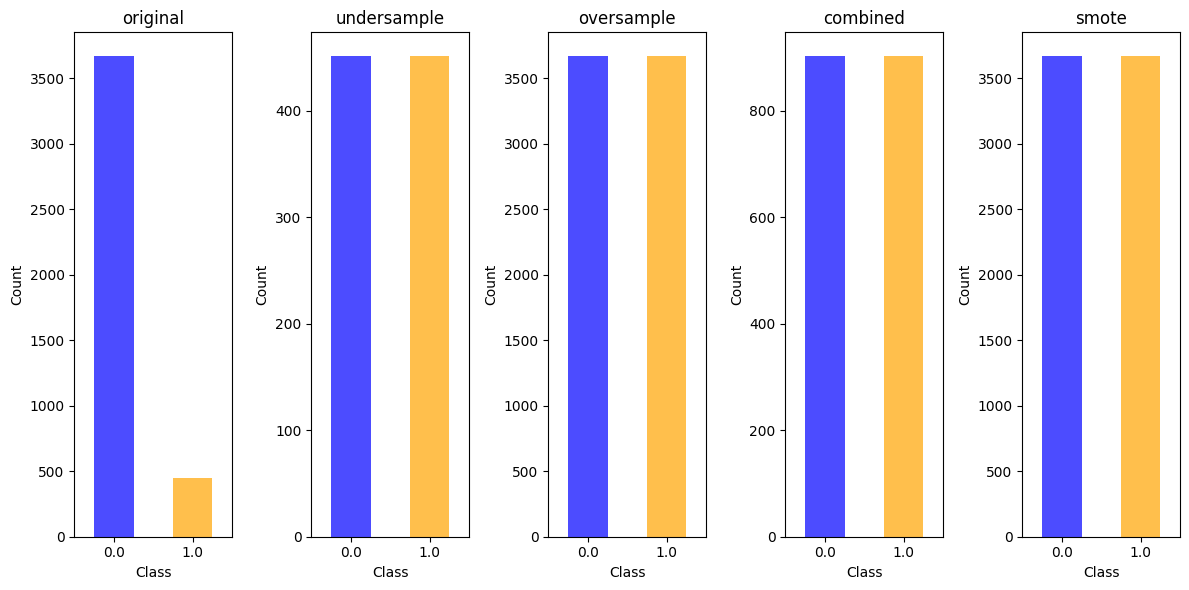

In [10]:
def split_data(data, test_size=0.30, random_state=42):
    '''returns X_train, X_test, y_train, y_test'''
    y = data['y']
    X = data.drop(columns=['y'])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    return X_train, X_test, y_train, y_test

def default(X_train, y_train):
    return X_train, y_train

def undersample_data(X_train, y_train, random_state=42):
    # Separate majority and minority classes
    majority = X_train[y_train == y_train.value_counts().idxmax()]
    minority = X_train[y_train != y_train.value_counts().idxmax()]
    
    # Downsample majority class
    majority_downsampled = resample(
        majority,
        replace=False,  # No replacement
        n_samples=len(minority),  # Match minority size
        random_state=random_state  # Reproducibility
    )
    
    # Combine and shuffle
    X_train_balanced = pd.concat([majority_downsampled, minority]).sample(frac=1, random_state=random_state)
    y_train_balanced = y_train[X_train_balanced.index]
    
    return X_train_balanced, y_train_balanced

def oversample_data(X_train, y_train, random_state=42):
    # Separate majority and minority classes
    majority = X_train[y_train == y_train.value_counts().idxmax()]
    minority = X_train[y_train != y_train.value_counts().idxmax()]
    
    # Upsample minority class
    minority_upsampled = resample(
        minority,
        replace=True,  # Allow replacement
        n_samples=len(majority),  # Match majority size
        random_state=random_state  # Reproducibility
    )
    
    # Combine and shuffle
    X_train_balanced = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=random_state)
    y_train_balanced = y_train[X_train_balanced.index]
    
    return X_train_balanced, y_train_balanced

def combined_sampling(X_train, y_train, random_state=42):
    # Separate majority and minority classes
    majority = X_train[y_train == y_train.value_counts().idxmax()]
    minority = X_train[y_train != y_train.value_counts().idxmax()]
    
    # Downsample majority class
    majority_downsampled = resample(
        majority,
        replace=False,
        n_samples=len(minority) * 2,  # Reduce to twice the size of minority
        random_state=random_state
    )
    
    # Upsample minority class
    minority_upsampled = resample(
        minority,
        replace=True,
        n_samples=len(majority_downsampled),  # Match new majority size
        random_state=random_state
    )
    
    # Combine and shuffle
    X_train_balanced = pd.concat([majority_downsampled, minority_upsampled]).sample(frac=1, random_state=random_state)
    y_train_balanced = y_train[X_train_balanced.index]
    
    return X_train_balanced, y_train_balanced

def smote_sampling(X_train, y_train, random_state=42):
    smote = SMOTE(random_state=random_state)
    
    # Apply SMOTE
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    return X_smote, y_smote

def get_sampling_methods():
    sampling_methods = {
        'original': default,
        'undersample': undersample_data,
        'oversample': oversample_data,
        'combined': combined_sampling,
        'smote': smote_sampling
    }
    
    return sampling_methods

def visualize_sampling_effects(data):

    y = data['y']
    X = data.drop(columns=['y'])
    # Prepare the distributions for visualization
    distributions = {}
    sampling_methods = get_sampling_methods()
    
    # Collect class distributions for each sampling method
    for method_name in sampling_methods.keys():
        _, y_sampled = sampling_methods[method_name](X, y)
        distributions[method_name] = y_sampled.value_counts().sort_index()
    
    # Visualize the distributions
    plt.figure(figsize=(12, 6))
    num_methods = len(distributions)
    
    for idx, (method, distribution) in enumerate(distributions.items()):
        plt.subplot(1, num_methods, idx + 1)
        distribution.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
        plt.title(method)
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

def run_visualizer():
    data = preprocessing()
    visualize_sampling_effects(data)

run_visualizer()


### Testing Linear Separability with a Perceptron


In [11]:
def perceptron_linearity():
    data = preprocessing()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = split_data(data)

    # Train the perceptron
    model = Perceptron(max_iter=1000, tol=1e-3, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Check if the dataset is linearly separable
    if accuracy == 1.0:
        print("The dataset is linearly separable.")
    else:
        print("The dataset is not linearly separable.")

perceptron_linearity()

The dataset is not linearly separable.


Since the data is not linearly separable, more advanced models such as Random Forest or Gradient Boosting Machine will likely be most effective for this dataset.

## Model Evaluation Methods

Another issue that arises due to the imbalanced nature of this dataset is the evaluation of models. Normally, measuring the performance of a machine learning model is quite simple: Measure the accuracy of the model on a test set of data. Unfortunately, it is not as easy with imbalanced data. A naive model trained on imbalanced data, which simply categorizes all of the samples into the majority class, will still achieve a high accuracy on a training set of equally imbalanced data. Because the model assumes all samples are of the majority class, and most of them are, its predictions will be mainly correct. But the model is useless when it comes to actually distinguishing between classes.

This is where alternate evaluation metrics, such as recall, F1 score and Precision-Recall AUC, come into play.

Evaluation based on precision is fairly self-explanatory. When predicting whether a sample does or does not belong to a given class, precision is the proportion of identified positives that were correctly deemed positive. In other words: Of all the samples a model claims belong to a class, precison is the percentage of these samples that actually do belong to the class. As discussed earlier, precison on it's own is not a reliable metric for imbalanced data.

Recall, on the other hand, is more useful. Recall is the proportion of actual positives that were correctly identified. In other words: Of all the samples a dataset that actually belong to a class, recall measures how many of these a model correctly identified. This is used to specifically measure how well the model identifies positive instances of the minority class, and is therefore a useful metric in our case.

The F1 Score is the average between recall and precision of a model’s performance. The F1 score balances the trade-off between these two metrics, focusing on the performance of the model with respect to the minority class.

The Precision-Recall curve is a curve that plots precision against recall at different decision thresholds (probability values at which the model decides to classify a sample as one or the other class). The PR-AUC is the area under this curve, and ranges from zero to one. The higher the PR-AUC, the better the model is at predicting the minority class.

All of these metrics are valuable ways of evaluating machine learning models. Recall, F1 Score, and PR-AUC are particularly useful for cases of imbalanced data, so we have utilized all of these while measuring our models' performance.


In [12]:
def generate_model_scores(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    # Calculate Recall
    recall = recall_score(y, y_pred, zero_division=0)
    
    # Calculate F1 Score
    f1 = f1_score(y, y_pred, zero_division=0)
    
    # Calculate Accuracy
    accuracy = accuracy_score(y, y_pred)
    
    # Generate confusion matrix
    confusion = confusion_matrix(y, y_pred)

    # Generate classification report
    classification = classification_report(y, y_pred, zero_division=0, output_dict=True)
        
    # Compute precision-recall curve
    precision2, recall2, _ = precision_recall_curve(y, y_prob)

    # Compute PR AUC
    pr_auc = auc(recall2, precision2)
    
    # Compute ROC AUC
    roc_auc = roc_auc_score(y, y_prob)
    
    # Initialize the return dictionary with basic metrics
    classification_expanded = {
        'accuracy': accuracy,
        'recall': recall,
        'f1': f1,
        'confusion': confusion,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
    }
    
    # Adding the entire classification report into the dictionary
    for label, metrics in classification.items():
        # For each label in the classification report, add the precision, recall, f1, and support
        if isinstance(metrics, dict):  # Checking if the value is a dictionary (i.e., for each class)
            for metric_name, value in metrics.items():
                classification_expanded[f'{label}_{metric_name}'] = value
        else:
            # For accuracy, macro avg, and weighted avg which are not per-class but overall metrics
            classification_expanded[label] = metrics

    return classification_expanded


def get_average_score_list(score_list):
    # Initialize dictionaries for sums and counts
    sum_dict = {}
    count_dict = {}
    average_dict = {}

    # Iterate through each dictionary in score_list
    for scores in score_list:
        for score, value in scores.items():
            # Handle confusion matrix (NumPy array)
            if score == "confusion":
                if isinstance(value, np.ndarray):  # Check if it's a numpy array
                    if score not in sum_dict:
                        sum_dict[score] = np.zeros_like(value)
                        count_dict[score] = 0
                    sum_dict[score] += value
                    count_dict[score] += 1
            
            # Handle other scores (numerical values)
            else:
                if score not in sum_dict:
                    sum_dict[score] = 0
                    count_dict[score] = 0
                sum_dict[score] += value
                count_dict[score] += 1

    # Compute averages and store in average_dict
    for score in sum_dict:
        if score == "classification" or score == "confusion":
            # Special handling for classification and confusion
            average_matrix = sum_dict[score] / count_dict[score]
            average_dict[score] = average_matrix
        else:
            # Regular averaging for numerical scores
            average_value = sum_dict[score] / count_dict[score]
            average_dict[score] = average_value
    
    return average_dict
    

### Custom Grid Search

One very important aspect of training a machine learning model is optimizing its hyperparameters. This is generally done by training models on a variety of different combinations of hyperparamters and evaluating the models to find the combination that is most effective. In our case, it was not as simple as using a GridSearch, as we needed to alter our training data using multiple different types of sampling/weighting methods, but then evaluate model performance on unsampled data.

This is why we have created a sort of custom grid search function. This function manually splits the data into k folds. Then, for each fold, it samples/weights the training data on the training folds, trains the model, and evaluates the model on the un-sampled/weighted validation fold. This way, each model's hyperparameters can be optimized without the models overfitting to the altered training data.

In [13]:
def evaluate_kfold_scores(score_list, metrics, weights=None):
    # Extract the values for all metrics
    average_dict = get_average_score_list(score_list)
    
    # Initialize a combined score
    combined_score = 0.0
    
    # If weights are provided, ensure they sum to 1
    if weights:
        if len(weights) != len(metrics):
            raise ValueError("Number of weights must match number of metrics.")
        weight_sum = sum(weights)
        if weight_sum != 1:
            raise ValueError("Weights must sum to 1.")
    else:
        # If no weights are provided, treat all metrics equally (i.e., weights of 1)
        weights = [1 / len(metrics)] * len(metrics)
    
    # Calculate the weighted combined score
    for metric, weight in zip(metrics, weights):
        metric_score = average_dict.get(metric)
        if metric_score is None:
            raise ValueError(f"Metric '{metric}' not found in the average scores.")
        combined_score += metric_score * weight
    
    return combined_score
    
def KFold_model(model, params, sampling_method, X_train, y_train, random_state=42, cv=None):
    if cv is None:
        cv = KFold(n_splits=5, random_state=random_state)
   
    scores = []
 
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data using integer-location based indexing (iloc)
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]
 
        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = sampling_method(X_train_fold, y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = generate_model_scores(model_obj, X_val_fold, y_val_fold)
        scores.append(score)
    return np.array(scores)

### Dynamic Model-Evaluation Function

This is the function we created for training, optimization, and evaluation of the various machine learning models we utilized for our project.

Given a model type, metrics for evaluation, and different hyperparameters to try, it will:

- Preprocesses the data
- Retrieve the training data based on various sampling methods
- Split the raw data into train and test
- Loops through the sampling methods, and for each:
  - Loop through the combinations of hyperparameters
    - Use the custom grid search function to find the best hyperparamters for that model and sampling method
    - Evaluates the model's score
    - Append all of that models info to a list
    - Print its evaluation of that specific model
 
- Sort all of the models by score
- Choose the best model, reprint its info, and store said info
 
- Retreive the parameters and sample type from the best model
- Create a new ssample of the training data
- Fit a new model with that data
- Evaluate the model with unseen validation data, and return the scores

In [14]:
def find_best_model(model_type, evaluation_metrics, params, random_state=42, print_individual=False):
    kf = KFold(n_splits=5, shuffle=False)

    data = preprocessing()
    sampling_methods = get_sampling_methods()
    X_train, X_test, y_train, y_test = split_data(data)

    model_tracker = []
   
    for method_name in sampling_methods.keys() :
        # Create a dictionary with all possible combinations of parameters
        for param_combination in itertools.product(*params.values()):
            param_dict = dict(zip(params.keys(), param_combination))
            model_info = {}
            sampling_method = sampling_methods[method_name]
            
            model_info['parameters'] = param_dict
            
        # Calculate the model evaluation score
            model_info['score list'] = KFold_model(model_type, param_dict, sampling_method, X_train, y_train, random_state, cv=kf)
       
        # Add sampler method name to the dictionary
            model_info['sampler'] = method_name
        
        # Parse score from list
            model_info['score'] = evaluate_kfold_scores(model_info['score list'], evaluation_metrics)            
        
        # Append the current parameter combination and its evaluation score to the score tracker
            model_tracker.append(model_info)
       
        # Print the current parameter dictionary
            if print_individual :
                print(f"SAMPLER {model_info['sampler']} --- PARAMETERS {model_info['parameters']} --- COMBINED SCORE {evaluation_metrics} -> {model_info['score']}")

    best_model_info = sorted(model_tracker, key=lambda x: x['score'], reverse=True)[0]
    
    best_model_avg_score_dict = get_average_score_list(best_model_info['score list'])
    
    #Print Information about best model found in kfolds
    print("-"*40)
    print("BEST TEST MODEL DATA")
    print(f"Sampling style: {best_model_info['sampler']}")
    print(f"HyperParameters: {best_model_info['parameters']}")
    print(f"Combined Metric Score: {best_model_info['score']}")
    for metric in evaluation_metrics :
        print(f"{metric}: {best_model_avg_score_dict[metric]}")
        
        
    #Create a new model with the same parameters and train it, then test it
    
    # Get the best tested models final parameters
    best_parameters = best_model_info['parameters']
    
    # Use the best sampling method for train data
    best_method_name = best_model_info['sampler']
    best_sampling_method = sampling_methods[best_method_name]
    
    # Sample the train data in the best found method
    X_train_final_sample, y_train_final_sample = best_sampling_method(X_train, y_train)
    
    # Train a new model with the train data using  the best sampling style
    final_model = model_type(**best_parameters).fit(X_train_final_sample, y_train_final_sample)
    
    # Score it with the untouched Test data
    final_scores = generate_model_scores(final_model, X_test, y_test)
    
    #Print its metrics
    print("-"*40)
    print("NEW MODEL ON UNSEEN DATA")
    print(f"SAMPLER {best_model_info['sampler']} --- PARAMETERS {best_model_info['parameters']}")
    for metric in evaluation_metrics :
        print(f"{metric}: {final_scores[metric]}")
    
    final_metrics = {
                    'scores': final_scores,
                    'parameters': best_parameters,
                    'sampler': best_method_name,
        }
        
    return final_metrics



Example Metrics

accuracy: 0.9122430435201233

recall: 0.400532766455376

f1: 0.49942322792695765

confusion: [[500.2  12.4]
           [ 38.2  25.8]]

pr_auc: 0.5678143502981878

0.0_precision: 0.929039282659617

0.0_recall: 0.9758090668311888

0.0_f1-score: 0.951820212758728

0.0_support: 512.6

1.0_precision: 0.6688456934323536

1.0_recall: 0.400532766455376

1.0_f1-score: 0.49942322792695765

1.0_support: 64.0

macro avg_precision: 0.7989424880459853

macro avg_recall: 0.6881709166432824

macro avg_f1-score: 0.7256217203428428

macro avg_support: 576.6

weighted avg_precision: 0.9008360934812236

weighted avg_recall: 0.9122430435201233

weighted avg_f1-score: 0.9020467177053444

weighted avg_support: 576.6

In [15]:
# Function for evaluating default models
def test_default(model):
    data = preprocessing()
    knn_X_train, knn_X_test, knn_y_train, knn_y_test = split_data(data)
    model.fit(knn_X_train, knn_y_train)
    scores = generate_model_scores(model, knn_X_test, knn_y_test)
    print("-------------Generic Model Scores:--------------")
    for metric in ['recall', 'pr_auc', 'f1']:
        print(f"{metric}: {scores[metric]}")
    print("------------------------------------------------")

##### Below, we have trained and optimized 7 different machine learning models. In the output beneath each celll, you can see the scores from a generic model before our manipulations, then the scores from our optimized models. 

##### As you can see, the generic model scores show worse performance. They generally have a high precision, but a very poor recall and subpar F1 Score, indicating they were not effective at identifying the samples from the minority class and simply overclassified into the majority class. This shows our optimized models have some promising success in training.

# KNN Model Testing

In [17]:
# Getting the best model
def test_knn():
    params = {
        'n_neighbors': [1, 3, 5, 7, 10, 15, 20, 30, 50],
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3],
        'leaf_size': [10, 20, 30],
    }
    metrics = ['recall', 'pr_auc', 'f1']
    model_type = KNeighborsClassifier
    print("Running KNN Model with small dataset")
    final_metrics = find_best_model(model_type, metrics, params)
    return final_metrics

# Testing a generic model
test_default(KNeighborsClassifier())

# Testing our optimized model
KNN_metrics = test_knn()

-------------Generic Model Scores:--------------
recall: 0.2900763358778626
pr_auc: 0.49712262163060406
f1: 0.36538461538461536
------------------------------------------------
Running KNN Model with small dataset
----------------------------------------
BEST TEST MODEL DATA
Sampling style: smote
HyperParameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 2, 'leaf_size': 10}
Combined Metric Score: 0.6498791853409043
recall: 0.9081031408629746
pr_auc: 0.5241153987833684
f1: 0.5174190163763701
----------------------------------------
NEW MODEL ON UNSEEN DATA
SAMPLER smote --- PARAMETERS {'n_neighbors': 30, 'weights': 'distance', 'p': 2, 'leaf_size': 10}
recall: 0.8854961832061069
pr_auc: 0.5301276009129613
f1: 0.48434237995824636


SAMPLER smote --- PARAMETERS {'n_neighbors': 30, 'weights': 'distance', 'p': 2, 'leaf_size': 10}

# Logistic Regression Testing

In [29]:
# Evaluation of a Logistic Regression model
def test_logistic_regression():

    params = {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [1000, 2000],
        'tol': [1e-4, 1e-3, 1e-2],
        'class_weight': ['balanced', None],
        'n_jobs': [-1]
    }
    metrics = ['recall', 'pr_auc', 'f1']
    model_type = LogisticRegression
    print("Running Logistic Regression Model with small dataset")
    final_metrics = find_best_model(model_type, metrics, params)
    return final_metrics

# Testing a generic model
test_default(LogisticRegression(random_state=42))

# Testing our optimized model
LR_metrics = test_logistic_regression()

-------------Generic Model Scores:--------------
recall: 0.40458015267175573
pr_auc: 0.5484896606142412
f1: 0.4608695652173913
------------------------------------------------
Running Logistic Regression Model with small dataset


c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\tucla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

----------------------------------------
BEST TEST MODEL DATA
Sampling style: oversample
HyperParameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 2000, 'tol': 0.01, 'class_weight': 'balanced', 'n_jobs': -1}
Combined Metric Score: 0.6920826445697198
recall: 0.8707660999058504
pr_auc: 0.6127984853184745
f1: 0.5926833484848346
----------------------------------------
NEW MODEL ON UNSEEN DATA
SAMPLER oversample --- PARAMETERS {'C': 1, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 2000, 'tol': 0.01, 'class_weight': 'balanced', 'n_jobs': -1}
recall: 0.8473282442748091
pr_auc: 0.533338149531215
f1: 0.5522388059701493


SAMPLER oversample --- PARAMETERS {'C': 1, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 1000, 'tol': 0.01, 'class_weight': None, 'n_jobs': -1}

# SVM Classifier Testing

In [31]:
#Evaluation of an SVC

def test_svms():
    params = {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 1, 0.01],
        'probability': [True],
        'class_weight': ['balanced', None],
        'kernel': ['rbf'],
    }
    metrics = ['recall', 'pr_auc', 'f1']
    model_type = SVC
    print("Running SVC Model with small dataset")
    final_metrics = find_best_model(model_type, metrics, params)
    return final_metrics

# Testing a generic model
test_default(SVC(probability=True, random_state=42))

# Testing our optimized model
SVM_metrics = test_svms()

-------------Generic Model Scores:--------------
recall: 0.366412213740458
pr_auc: 0.5563058861823402
f1: 0.4528301886792453
------------------------------------------------
Running SVC Model with small dataset
----------------------------------------
BEST TEST MODEL DATA
Sampling style: original
HyperParameters: {'C': 1, 'gamma': 'auto', 'probability': True, 'class_weight': 'balanced', 'kernel': 'rbf'}
Combined Metric Score: 0.6896315716598813
recall: 0.8903156325605959
pr_auc: 0.6054447284979727
f1: 0.5731343539210755
----------------------------------------
NEW MODEL ON UNSEEN DATA
SAMPLER original --- PARAMETERS {'C': 1, 'gamma': 'auto', 'probability': True, 'class_weight': 'balanced', 'kernel': 'rbf'}
recall: 0.8778625954198473
pr_auc: 0.5177101058923509
f1: 0.5373831775700935


# Random Forest Testing


In [32]:
#Evaluation of a Random Forest

def test_rf():
    params = {
        'n_estimators': [10, 50, 100, 200, 1000],
        'max_depth': [None, 4, 6, 10, 50],
        'min_samples_split': [2, 5, 10],  
        'class_weight': ['balanced', None],
        'random_state': [42],
        'n_jobs': [-1]
    }
    metrics = ['recall', 'pr_auc', 'f1']
    model_type = RandomForestClassifier
    print("Running Random Forest Model with small dataset")
    final_metrics = find_best_model(model_type, metrics, params)
    return final_metrics

# Testing a generic model
test_default(RandomForestClassifier(random_state=42))

# Testing our optimized model
RF_metrics = test_rf()

-------------Generic Model Scores:--------------
recall: 0.3816793893129771
pr_auc: 0.5596799836875275
f1: 0.46511627906976744
------------------------------------------------
Running Random Forest Model with small dataset
----------------------------------------
BEST TEST MODEL DATA
Sampling style: undersample
HyperParameters: {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 5, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}
Combined Metric Score: 0.6861933611364991
recall: 0.9175044313963406
pr_auc: 0.5721350194945425
f1: 0.5689406325186142
----------------------------------------
NEW MODEL ON UNSEEN DATA
SAMPLER undersample --- PARAMETERS {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 5, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}
recall: 0.8931297709923665
pr_auc: 0.5266078037992002
f1: 0.5234899328859061


# Gradient Boosting Testing

In [25]:
def test_gradient_boosting():
    params = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [10, 50, 100],
        'max_depth': [5, 7, 10],
        'random_state': [42],
        
    }
    metrics = ['recall', 'pr_auc', 'f1']
    model_type = GradientBoostingClassifier
    print("Running Gradient Boosting Model with small dataset")
    final_metrics = find_best_model(model_type, metrics, params)
    return final_metrics

# Testing a generic model
test_default(GradientBoostingClassifier(random_state=42))

# Testing our optimized model
GB_metrics = test_gradient_boosting()

-------------Generic Model Scores:--------------
recall: 0.5038167938931297
pr_auc: 0.582498321546686
f1: 0.5258964143426295
------------------------------------------------
Running Gradient Boosting Model with small dataset
----------------------------------------
BEST TEST MODEL DATA
Sampling style: undersample
HyperParameters: {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'random_state': 42}
Combined Metric Score: 0.67375763252825
recall: 0.9010343478076128
pr_auc: 0.5664123373426697
f1: 0.5538262124344676
----------------------------------------
NEW MODEL ON UNSEEN DATA
SAMPLER undersample --- PARAMETERS {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'random_state': 42}
recall: 0.9083969465648855
pr_auc: 0.5209770664918052
f1: 0.5129310344827587


# Naive Bayes Testing

In [26]:
def test_naive_bayes():
    params = {
        'var_smoothing': [1e-9, 1e-8, 1e-7],
    }
    metrics = ['recall', 'pr_auc', 'f1']
    model_type = GaussianNB
    print("Running Naive Bayes Model with small dataset")
    final_metrics = find_best_model(model_type, metrics, params)
    return final_metrics

# Testing a generic model
test_default(GaussianNB())

# Testing our optimized model
NB_metrics = test_naive_bayes()

-------------Generic Model Scores:--------------
recall: 0.9465648854961832
pr_auc: 0.42063596201575165
f1: 0.2333019755409219
------------------------------------------------
Running Naive Bayes Model with small dataset
----------------------------------------
BEST TEST MODEL DATA
Sampling style: original
HyperParameters: {'var_smoothing': 1e-07}
Combined Metric Score: 0.5439546500778237
recall: 0.8728547031265291
pr_auc: 0.4488776448242759
f1: 0.3101316022826661
----------------------------------------
NEW MODEL ON UNSEEN DATA
SAMPLER original --- PARAMETERS {'var_smoothing': 1e-07}
recall: 0.8854961832061069
pr_auc: 0.42955314354627094
f1: 0.2761904761904762


In [35]:
def test_decision_tree():
    params = {
            'max_depth': [4, 6, 10, 15, 50, None],
            'max_leaf_nodes': [None, 10, 20, 50],
            'max_features': [None, 'sqrt', 'log2', 0.5, 0.75],
            'class_weight': [None, 'balanced'], 
            'splitter': ['best', 'random'],
            'random_state': [42]
            }
    metrics = ['recall', 'pr_auc', 'f1']
    model_type = DecisionTreeClassifier
    print("Running Decision Tree Model with small dataset")
    final_metrics = find_best_model(model_type, metrics, params)
    return final_metrics

# Testing a generic model
test_default(DecisionTreeClassifier())

# Testing our optimized model
DT_metrics = test_decision_tree()

-------------Generic Model Scores:--------------
recall: 0.5725190839694656
pr_auc: 0.5207776704472417
f1: 0.487012987012987
------------------------------------------------
Running Decision Tree Model with small dataset
----------------------------------------
BEST TEST MODEL DATA
Sampling style: oversample
HyperParameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'max_features': None, 'class_weight': None, 'splitter': 'best', 'random_state': 42}
Combined Metric Score: 0.6779488709560008
recall: 0.8841834873366693
pr_auc: 0.5538703500932737
f1: 0.5957927754380595
----------------------------------------
NEW MODEL ON UNSEEN DATA
SAMPLER oversample --- PARAMETERS {'max_depth': 4, 'max_leaf_nodes': 10, 'max_features': None, 'class_weight': None, 'splitter': 'best', 'random_state': 42}
recall: 0.8625954198473282
pr_auc: 0.4273428835549342
f1: 0.551219512195122


The metrics used in this analysis—such as C1 Recall, C1 Precision, F1 Score, PR AUC, and confusion matrices—are specifically chosen to assess how well our models identify the minority class, which in this case represents customers who subscribe to a term deposit. We focus on True Positives (TP) and aim to minimize False Negatives (FN) because correctly identifying subscribers is crucial for the bank's success. A True Positive indicates a customer who genuinely subscribes, and identifying them allows the bank to target the right customers with offers. On the other hand, False Negatives are customers who would have subscribed but are incorrectly classified as non-subscribers, which represents lost business opportunities. Since the dataset is imbalanced, focusing on recall (True Positive Rate) is essential, as it directly measures a model's ability to find as many actual subscribers as possible, reducing the risk of overlooking valuable leads. This approach ensures that our models prioritize capturing the minority class, which is the most critical factor for improving business outcomes.

# Comparison of all models

In [36]:
def compare_models(models):
    

    # Extract relevant metrics from each model
    primary_metrics_list = []
    for model_name, model_metrics in models.items():
        metrics = {
            "Model": model_name,
            "Sampler": model_metrics['sampler'],
            # "Parameters": model_metrics['parameters'],
            "C1 Recall": model_metrics['scores']["1.0_recall"],
            "C1 Precision": model_metrics['scores']["1.0_precision"],
            "C1 F1 Score": model_metrics['scores']["1.0_f1-score"],
            "PR AUC": model_metrics['scores']["pr_auc"],
            
            "Macro AVG Recall": model_metrics['scores']["macro avg_recall"],
            "Macro AVG F1": model_metrics['scores']["macro avg_f1-score"],
            "Weighted AVG Recall": model_metrics['scores']["weighted avg_recall"],
            "Weighted AVG F1": model_metrics['scores']["weighted avg_f1-score"],
            "Confusion": model_metrics['scores']["confusion"],
        }
        primary_metrics_list.append(metrics)

    # Create a DataFrame to display the metrics
    df = pd.DataFrame(primary_metrics_list)

    # Apply pandas Styler for aesthetic formatting
    styled_df = df.style.set_table_styles([
        {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'black'), ('font-weight', 'bold')]},  # Header text color to black
        {'selector': 'tbody td', 'props': [('padding', '10px'), ('text-align', 'center'), ('font-size', '14px'), ('color', 'black')]},  # Body text color to black
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Even rows with light gray background
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', 'white')]},  # Odd rows with white background
        {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},  # Table layout
        {'selector': 'th, td', 'props': [('border', '1px solid #ddd'), ('padding', '8px'), ('text-align', 'center')]},  # Borders and padding
    ])

    # Display the styled DataFrame
    return styled_df, models
models = {
        "Naive Bayes": NB_metrics,
        "Random Forest": RF_metrics,
        "Linear Regression": LR_metrics,
        "Knn": KNN_metrics,
        "SVC": SVM_metrics,
        "Gradient Boosting": GB_metrics,
        "Decision Tree": DT_metrics
    }
table, models = compare_models(models)

table


,Model,Sampler,C1 Recall,C1 Precision,C1 F1 Score,PR AUC,Macro AVG Recall,Macro AVG F1,Weighted AVG Recall,Weighted AVG F1,Confusion
0,Naive Bayes,original,0.885496,0.163611,0.276190,0.429553,0.674422,0.451821,0.508091,0.590222,[[512 593] [ 15 116]]
1,Random Forest,undersample,0.893130,0.370253,0.523490,0.526608,0.856520,0.709152,0.827670,0.855459,[[906 199] [ 14 117]]
2,Linear Regression,oversample,0.847328,0.409594,0.552239,0.533338,0.851266,0.732641,0.854369,0.874803,[[945 160] [ 20 111]]
3,Knn,smote,0.885496,0.333333,0.484342,0.530128,0.837771,0.680204,0.800162,0.834549,[[873 232] [ 15 116]]
4,SVC,original,0.877863,0.387205,0.537383,0.517710,0.856578,0.720257,0.839806,0.864367,[[923 182] [ 16 115]]
5,Gradient Boosting,undersample,0.908397,0.357357,0.512931,0.520977,0.857366,0.700191,0.817152,0.847756,[[891 214] [ 12 119]]
6,Decision Tree,oversample,0.862595,0.405018,0.551220,0.427343,0.856185,0.730993,0.851133,0.872659,[[939 166] [ 18 113]]


This set of model metrics provides an early indication of model performance but is not the final evaluation. The results are based on a smaller portion of the data, which might not capture the full complexity of the dataset. It’s important to note that performance on this subset could differ when tested on the complete dataset, especially when dealing with imbalanced data where model behavior can vary across different segments of the data. While these results provide useful insights, the true test of model performance will come when the models are evaluated on the full dataset, where they may encounter a more diverse range of examples, including edge cases and instances that are more difficult to classify.

From this smaller portion, Random Forest (undersample) stands out with the highest C1 Recall (0.893), showing its effectiveness at identifying the minority class (subscribers to the term deposit) even in this smaller dataset. Its F1 Score (0.523) and PR AUC (0.527) are also strong, though there's room for improvement, especially when compared to models like Linear Regression (oversample), which has a higher F1 Score (0.552). Linear Regression also shows strong C1 Recall (0.847), demonstrating good performance in identifying true positives in this smaller subset, although it doesn't perform as well as Random Forest in PR AUC.

Gradient Boosting (undersample) and SVC (original) also perform well, with Gradient Boosting showing a high C1 Recall (0.908) and a PR AUC of 0.521, but its F1 Score (0.513) is slightly lower than that of Linear Regression. SVC and Decision Tree (oversample) both perform similarly with balanced recall and precision, though they fall behind in terms of the F1 Score and PR AUC.

Looking at the confusion matrices, we can see that Random Forest and Gradient Boosting have a good number of true positives (117 for Random Forest and 119 for Gradient Boosting) while keeping the false negatives relatively low (14 and 12, respectively), which is crucial for this task. On the other hand, models like Naive Bayes (original) show lower recall and F1 Scores, indicating less effectiveness at identifying the minority class in this subset.

In conclusion, while these results give a useful snapshot of model performance, they don't represent the final evaluation. The full dataset could yield different outcomes, especially as models encounter a broader range of data. Random Forest, Linear Regression, and Gradient Boosting show the most promise in this preliminary analysis, and their performance on the complete dataset should be closely monitored. The next step will involve testing these models on a more comprehensive dataset to confirm these findings and potentially fine-tune the models for even better performance.

## Evaluation of a each model on the full data set

All the previous content of this project was performed on a smaller sample of the dataset to increase computation and training times, but below we have trained the models on the full version to prove our models are generalizable to the rest of the data. As shown in the table, the models have comparable performaces on both data sets.

In [41]:
def full_evaluation(models):
    data = preprocessing(url="https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional-full.csv")
    X_train, X_test, y_train, y_test = split_data(data)
    sampling_methods = get_sampling_methods()
    
    final_model_info = {}
    
    for model_name, model_metrics in models.items():
        if model_name == "Random Forest" :
            model = RandomForestClassifier
        
        elif model_name == "Naive Bayes" :
            model = GaussianNB
        
        elif model_name == "Linear Regression" :
            model = LogisticRegression
        
        elif model_name == "Knn" :
            model = KNeighborsClassifier
            
        elif model_name == "SVC" :
            model = SVC
            # continue
        
        elif model_name == "Gradient Boosting" :
            model = GradientBoostingClassifier
            # continue
        
        elif model_name == "Decision Tree":
            model = DecisionTreeClassifier

        print(f"Running {model_name}")
        method = model_metrics['sampler']
        parameters = model_metrics['parameters']
        print(parameters)
        X_sampled, y_sampled = sampling_methods[method](X_train, y_train)
        
        model_obj = model(**parameters)
        model_obj.fit(X_sampled, y_sampled)
        
        scores = generate_model_scores(model_obj, X_test, y_test)
        
        final_model_info[model_name] = {
                                    'sampler': method,
                                    'scores' : scores,
        }
    
    return final_model_info
final_model_info = full_evaluation(models)
table, _ = compare_models(final_model_info)
table


Running Naive Bayes
{'var_smoothing': 1e-07}
Running Random Forest
{'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 5, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}
Running Linear Regression
{'C': 1, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 2000, 'tol': 0.01, 'class_weight': 'balanced', 'n_jobs': -1}
Running Knn
{'n_neighbors': 30, 'weights': 'distance', 'p': 2, 'leaf_size': 10}
Running SVC
{'C': 1, 'gamma': 'auto', 'probability': True, 'class_weight': 'balanced', 'kernel': 'rbf'}
Running Gradient Boosting
{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'random_state': 42}
Running Decision Tree
{'max_depth': 4, 'max_leaf_nodes': 10, 'max_features': None, 'class_weight': None, 'splitter': 'best', 'random_state': 42}


,Model,Sampler,C1 Recall,C1 Precision,C1 F1 Score,PR AUC,Macro AVG Recall,Macro AVG F1,Weighted AVG Recall,Weighted AVG F1,Confusion
0,Naive Bayes,original,0.746489,0.299268,0.427251,0.461165,0.759373,0.641400,0.769287,0.806177,[[8440 2489] [ 361 1063]]
1,Random Forest,undersample,0.931180,0.418693,0.577652,0.637247,0.881364,0.740628,0.843034,0.866030,[[9088 1841] [ 98 1326]]
2,Linear Regression,oversample,0.878511,0.438179,0.584716,0.569277,0.865873,0.748862,0.856148,0.875163,[[9325 1604] [ 173 1251]]
3,Knn,smote,0.906601,0.400434,0.555508,0.563727,0.864866,0.726253,0.832753,0.857633,[[8996 1933] [ 133 1291]]
4,SVC,original,0.926966,0.410959,0.569456,0.618752,0.876924,0.735002,0.838420,0.862381,[[9037 1892] [ 104 1320]]
5,Gradient Boosting,undersample,0.919944,0.435216,0.590889,0.637092,0.882197,0.750703,0.853153,0.873672,[[9229 1700] [ 114 1310]]
6,Decision Tree,oversample,0.900983,0.396968,0.551117,0.589758,0.861325,0.723439,0.830810,0.856032,[[8980 1949] [ 141 1283]]


After our experiments, it seems that Random Forest (undersample) is the most effective model for this dataset, as its recall of the minority class is excellent. Its C1 Recall (0.931) ensures that the model identifies the majority of true positives in the minority class, which is crucial for the bank's objectives. Additionally, its F1 Score (0.578) and PR AUC (0.637) are either better or marginally lower than those of other models, further solidifying its performance. Linear Regression (oversample) and Gradient Boosting (undersample) also exhibited relatively high performance, with strong recall scores and balanced metrics.

The importance of high recall in this case cannot be overstated. Recall, or the True Positive Rate, signifies how well the model identifies customers who did subscribe to the term deposit, out of all the actual subscribers. Our models excelled at identifying customers in the minority class—those who are likely to subscribe—ensuring that the bank does not miss out on potential business. This is the most crucial factor for the bank, as failure to identify a potential subscriber means lost opportunities.

Looking at the confusion matrices, we see that Random Forest has a high number of true positives (1326) and only a relatively small number of false negatives (98), confirming its effectiveness in capturing the minority class. Similarly, Gradient Boosting has an impressive C1 Recall (0.920), with a good balance of true positives (1310) and false negatives (114), suggesting it is also highly effective at identifying the minority class.

Although Linear Regression had a slightly lower recall (0.879), it still performed admirably in identifying true positives, with its confusion matrix showing a high number of true positives (1252) and fewer false negatives (172). The SVC and KNN models performed well in terms of recall but had a higher number of false negatives relative to their true positives, indicating that their ability to identify the minority class was slightly less robust.

We concluded that, due to the nature of this dataset and its representation, high recall makes these models viable. While the F1 Score and other metrics could benefit from further tuning, the recall results show that our models are successfully identifying customers in the minority class, which is the key factor in this task. The ability to recognize as many true positives as possible minimizes the risk of missed business opportunities for the bank.

Moving forward, we recognize the need for further research and development to improve precision, F1 scores, and other metrics. The models already outperform baseline, naive models, and with additional refinement, they can become even more effective. Through this project, we have learned more about handling imbalanced data and the techniques that can improve model performance. We are eager to continue refining our models and exploring new ways to enhance their accuracy and reliability.

Throughout our research for this project, we found the resources listed below to be helpful and informative.

- https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf
- https://www.kaggle.com/code/manishkc06/model-optimization-with-random-forest
- https://www.linkedin.com/advice/0/how-can-you-evaluate-machine-learning-models-imbalanced#:~:text=Alternative%20evaluation%20metrics%20for%20imbalanced,can%20distinguish%20between%20the%20classes.
- https://stats.stackexchange.com/questions/340854/random-forest-for-imbalanced-data
- https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html